In [1]:
import pandas as pd
from run_xgboost import proc_feats

df = pd.read_csv('../../notebooks/tmp/nhl/nhl_data_clean.csv')
new_df = proc_feats(df)
new_df.head(5)

,Unnamed: 0,date_time,season,game_id,game_type,game_seconds,period,period_time,period_seconds,event_type,...,shot_distance,shot_angle,distance_from_prev_event,time_from_prev_event,rebound,change_in_angle,speed,shot_type,empty_net,strength
0,0,2015-10-07T23:24:23Z,2015-2016,2015020001,R,51,1,00:51,51,0,...,34.53,10.01,154.28,11,0,0.00,14.03,7,0,Even
1,1,2015-10-07T23:24:38Z,2015-2016,2015020001,R,65,1,01:05,65,0,...,10.00,0.00,50.48,7,0,0.00,7.21,4,0,Even
2,2,2015-10-07T23:27:21Z,2015-2016,2015020001,R,66,1,01:06,66,0,...,14.04,4.09,4.12,1,1,4.09,4.12,4,0,Even
3,3,2015-10-07T23:25:24Z,2015-2016,2015020001,R,113,1,01:53,113,0,...,49.52,46.64,79.61,18,0,0.00,4.42,7,0,Even
4,4,2015-10-07T23:27:08Z,2015-2016,2015020001,R,157,1,02:37,157,0,...,28.02,2.05,22.47,5,0,0.00,4.49,5,0,Even


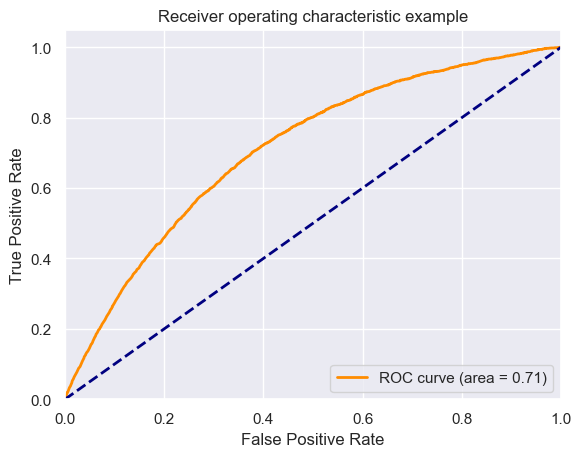

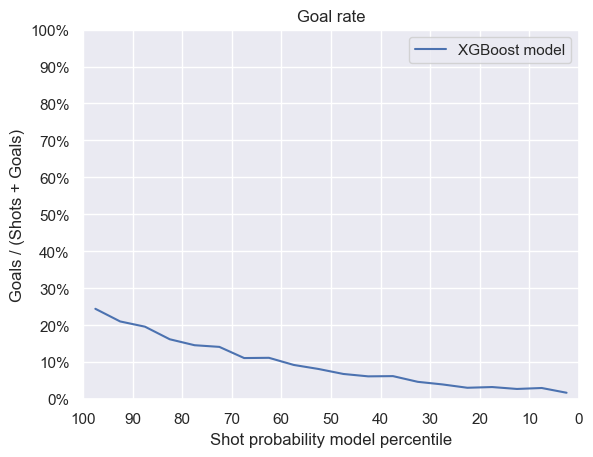

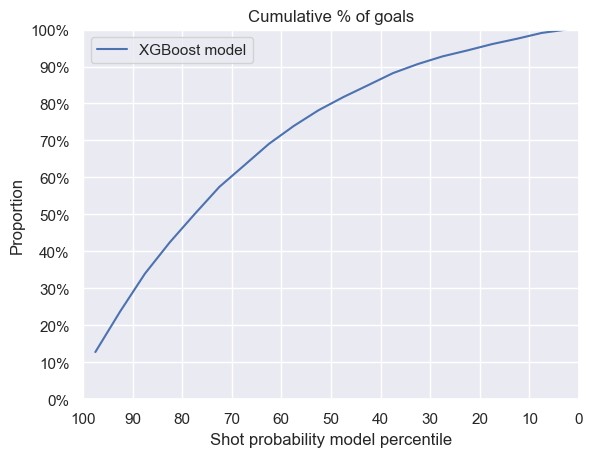

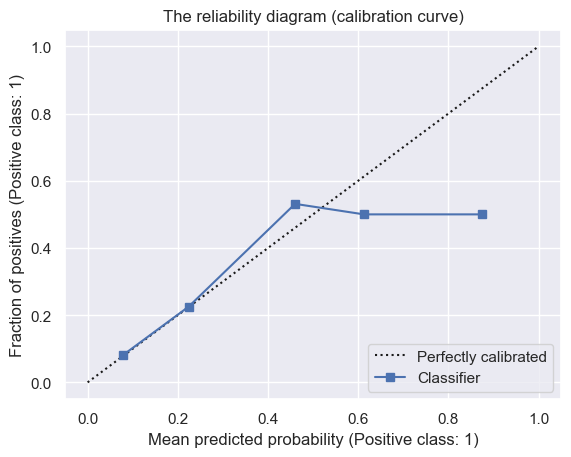

In [2]:
from run_xgboost import train_xgboost

train_xgboost(new_df, feat_num=2)

In [4]:
from sklearn.model_selection import train_test_split

feat_list = ['game_seconds', 'period', 'coord_x', 'coord_y', 'shot_distance', 'shot_angle', 'shot_type', 'prev_event_type', 'prev_coord_x', 'prev_coord_y', 
        'time_from_prev_event', 'distance_from_prev_event', 'rebound', 'change_in_angle', 'speed', 'empty_net']

feats = new_df[feat_list]
label = new_df[['event_type']]

X_train, X_val, y_train, y_val = train_test_split(feats, label, test_size=0.1)


In [11]:
from xgboost import XGBClassifier
# import packages for hyperparameters tuning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

hyperparams = {'booster': ['gbtree', 'gblinear', 'dart'],
              'objective':['binary:logistic'],
              'eta': [1, 0.1, 0.05],       # learning rate
              'max_depth': [3, 10, 18],
            #   'gamma': [0, 3, 6, 9],
            #   'min_child_weight': [0, 4, 7, 11],
              'subsample': [0.5, 1],
              'eval_metric': ['auc'],
              'seed': [1337]
              }

xgb_model = XGBClassifier()
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

clf = GridSearchCV(xgb_model, hyperparams, n_jobs=1, 
                   cv=skf,
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(feats, label)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=3, objective=binary:logistic, seed=1337, subsample=0.5; total time=   2.9s
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=3, objective=binary:logistic, seed=1337, subsample=0.5; total time=   2.7s
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=3, objective=binary:logistic, seed=1337, subsample=0.5; total time=   2.9s
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=3, objective=binary:logistic, seed=1337, subsample=1; total time=   2.1s
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=3, objective=binary:logistic, seed=1337, subsample=1; total time=   2.0s
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=3, objective=binary:logistic, seed=1337, subsample=1; total time=   2.0s
[CV] END booster=gbtree, eta=1, eval_metric=auc, max_depth=10, objective=binary:logistic, seed=1337, subsample=0.5; total time=  10.2s
[CV] 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'eta': [1, 0.1, 0.05], 'eval_metric': ['auc'],
                         'max_depth': [3, 10, 18],
                         'objective': ['binary:logistic'], 'seed': [1337],
                         'subsample': [0.5, 1]},
             scoring='roc_auc', verbose=2)

<AxesSubplot: >

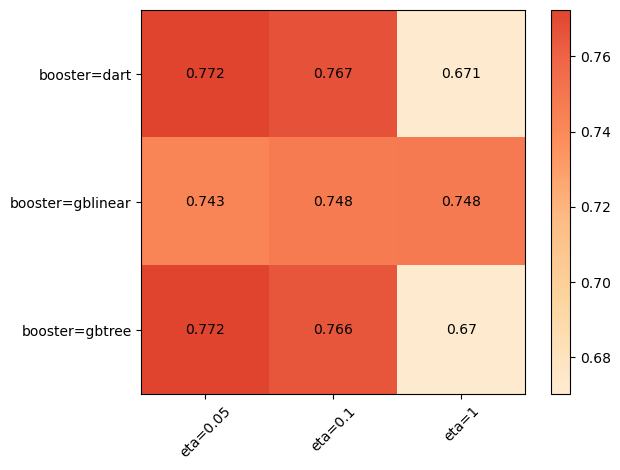

In [25]:
from sklearn_evaluation import plot

# grid_scores = clf.cv_results_
# print(grid_scores)

plot.grid_search(clf.cv_results_, change=('booster', 'eta'),
                 subset={'eval_metric': 'auc', 'max_depth': 10, 'objective': 'binary:logistic', 'seed': 1337, 'subsample': 0.5})
# plot.grid_search(clf.cv_results_, change=('max_depth', 'subsample'),
#                  subset={'eval_metric': 'auc','booster': 'dart', 'eta': 0.05, 'objective': 'binary:logistic', 'seed': 1337})

# print('Best AUC score:', clf.best_score_)
# print(clf.best_estimator_)
# print(clf.best_params_)

# test_probs = clf.predict_proba(X_val)[:,1]


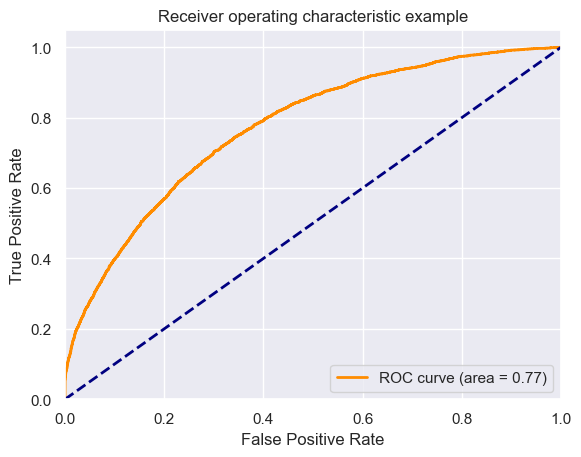

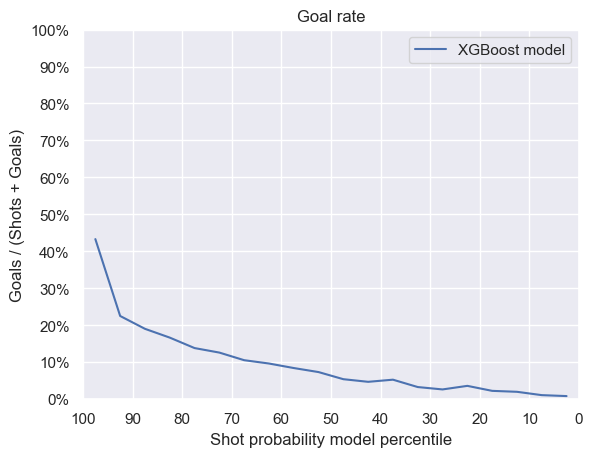

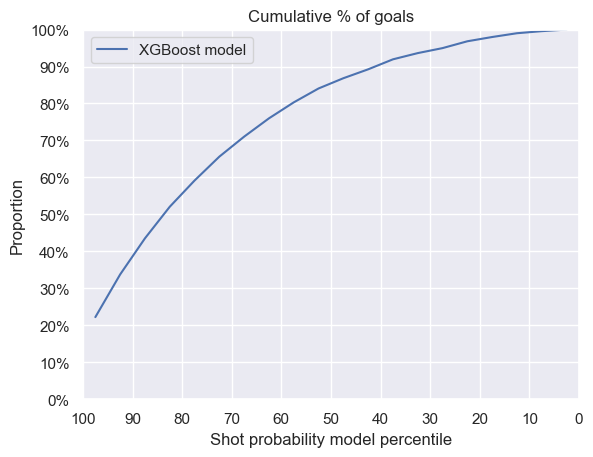

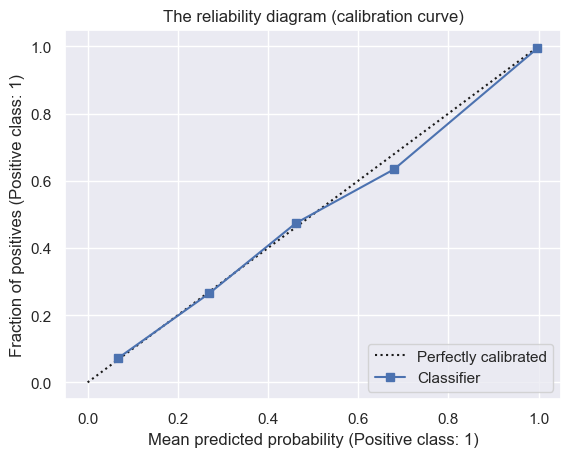

In [2]:
from run_xgboost import train_xgboost

xgboost_model, roc_auc = train_xgboost(new_df, feat_num=16)

In [3]:
xgboost_model.save_model('xgboost_all_feats.json')

In [4]:
# # Import comet_ml at the top of your file, before sklearn!
import os
from comet_ml import Experiment


# # Create an experiment with your api key
exp = Experiment(
    # api_key=os.environ.get('COMET_API_KEY'), # don’t hardcode!! 
    api_key='nswhJWNIpDxovklD8fxYpbxX4',
    project_name='ift6758-project',
    workspace='ds-team-9',
)

exp.log_model("models", "xgboost_all_feats.json")

exp.log_metrics({"auc": roc_auc})


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, xgboost. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ds-team-9/ift6758-project/3e573229f90f46e38ffae82de9df09f8

